In [6]:
import minepy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot, os, sys

from iminuit import Minuit

In [7]:
data_path = "../../Data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
data_file = uproot.open(data_path)
data_tree = data_file['tree']

features = "v0_chi2 v0_py1 v0_phi1 v0_px1 v0_px v0_px2 v0_phi2 v0_py \
v0_py2 pv0_y pv0_x ntrk_pv0 pv0_z v0_z v0_rxyErr a0xy \
a0 cosTheta v0_x v0_y v0_rxy v0_ks_mass".split(" ")

# features = data_tree.keys(data_tree.keys()[:139]
features.remove("v0_ks_mass")

N_data = None
df = data_tree.pandas.df(features, entrystop = N_data)
mass = data_tree.pandas.df(b"v0_ks_mass", entrystop = N_data)

In [39]:
df.pv0_x

entry
0         -0.639664
1         -0.668485
2         -0.668485
3         -0.668485
4         -0.711964
             ...   
5881539   -0.601378
5881540   -0.601378
5881541   -0.601378
5881542   -0.601378
5881543   -0.601378
Name: pv0_x, Length: 5881544, dtype: float32

In [10]:
from xgboost import XGBClassifier
import shap

In [11]:
from sklearn.model_selection import train_test_split
test_ratio = 0.1
df_train, df_test, mass_train, mass_test= train_test_split(df, mass, test_size = test_ratio)

In [12]:
mean, sig = 498.26, 7.005

from xgboost import XGBClassifier

# Apply range
mass = mass_train[(mass_train > 400) & (mass_train < 600)].dropna()

pseudo_true = mass[abs(mass - mean) <  sig].dropna()

am = len(pseudo_true)

# True false
low_false = mass[(mass  + 7 * sig < mean)|(mass  + 10 * sig > mean)].dropna().sample(am)
high_false = mass[(mass  - 10 * sig > mean)|(mass  - 7 * sig < mean)].dropna().sample(am)

# Make df
indicies = pd.concat([pseudo_true, low_false, high_false]).index

target = pd.Series(np.zeros(len(indicies), dtype = int), indicies, dtype = bool)
target.loc[pseudo_true.index] = 1

model = XGBClassifier()
model.fit(df_train.loc[target.index, :], target.astype(bool))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [13]:
# model = XGBClassifier()
# model.fit(df_train.loc[target.index, :], target.astype(bool))

In [26]:
explainer = shap.TreeExplainer(model)

In [27]:
shap_values = explainer.shap_values(df_train.iloc[:100000])

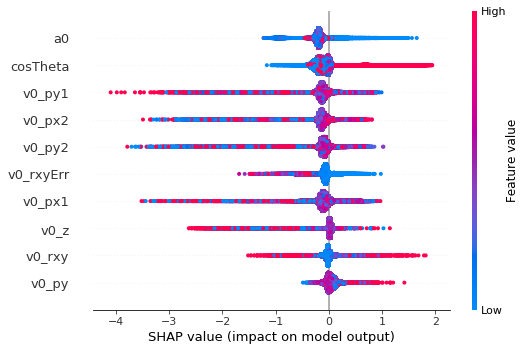

In [28]:
fig, ax = plt.subplots(figsize=(16, 8))
shap.summary_plot(shap_values, df_train.iloc[:100000], max_display = 10, show = False)
plt.savefig("../figures/shap_summary.png")

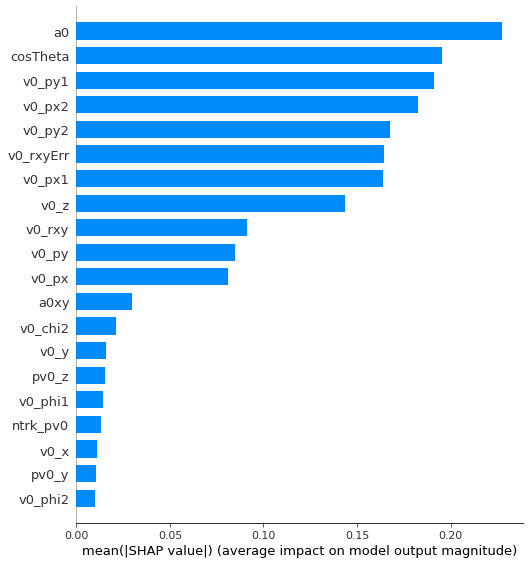

In [29]:
shap.summary_plot(shap_values, df_train.iloc[:100000], plot_type="bar")

In [30]:
explainer = shap.TreeExplainer(model)

In [31]:
shap_values = explainer.shap_values(df_test.iloc[:100000])

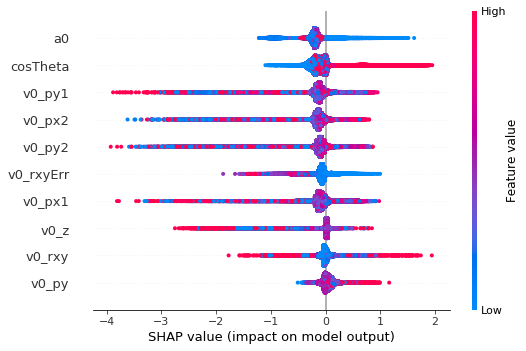

In [32]:
fig, ax = plt.subplots(figsize=(16, 8))
shap.summary_plot(shap_values, df_test.iloc[:100000], max_display = 10, show = False)
plt.savefig("../figures/shap_summary.png")

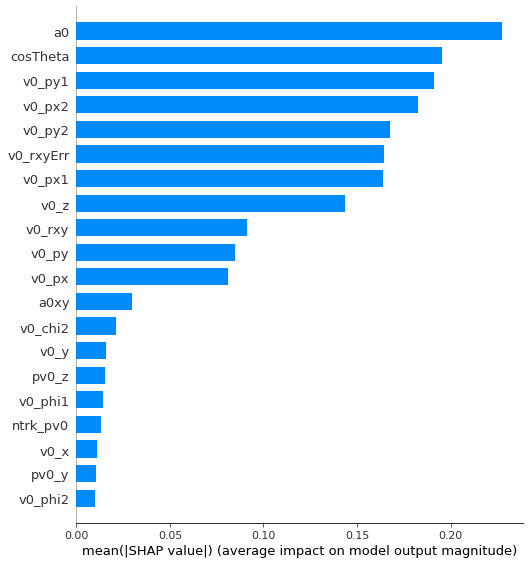

In [29]:
shap.summary_plot(shap_values, df_test.iloc[:100000], plot_type="bar")

In [19]:
df.columns[np.argsort(model.feature_importances_)], np.sort(model.feature_importances_)

(Index(['pv0_y', 'pv0_x', 'pv0_z', 'v0_x', 'v0_y', 'v0_phi2', 'ntrk_pv0',
        'v0_phi1', 'v0_chi2', 'v0_z', 'a0xy', 'v0_px', 'v0_py', 'v0_py1',
        'v0_py2', 'v0_px2', 'v0_px1', 'v0_rxy', 'v0_rxyErr', 'a0', 'cosTheta'],
       dtype='object'),
 array([0.00555824, 0.00595643, 0.00659076, 0.00809435, 0.00833744,
        0.00847793, 0.00868817, 0.00899427, 0.00994605, 0.01170036,
        0.01322636, 0.01941432, 0.02195839, 0.03030416, 0.03159852,
        0.0317871 , 0.03280158, 0.03683612, 0.03776901, 0.09863846,
        0.563322  ], dtype=float32))

In [20]:
features = df_test.columns[np.argsort(abs(shap_values[0]).mean(0))]
features = list(features)

In [34]:
np.array(df_test.columns)[np.argsort(abs(shap_values).mean(0))]

array(['a0', 'cosTheta', 'v0_py1', 'v0_px2', 'v0_py2', 'v0_rxyErr',
       'v0_px1', 'v0_z', 'v0_rxy', 'v0_py', 'v0_px', 'a0xy', 'v0_chi2',
       'v0_y', 'pv0_z', 'v0_phi1', 'ntrk_pv0', 'v0_x', 'pv0_y', 'v0_phi2',
       'pv0_x'], dtype=object)

In [35]:
shap_values.shape, .shape

SyntaxError: invalid syntax (<ipython-input-35-18af2c70e595>, line 1)

In [36]:
for i, j in zip(df_test.columns[np.argsort(abs(shap_values).mean(0))[::-1]], np.sort(abs(shap_values).mean(0))[::-1]):
    print(i, ":", j)

a0 : 0.22730483
cosTheta : 0.1963927
v0_py1 : 0.19088168
v0_px2 : 0.18073992
v0_py2 : 0.16586715
v0_rxyErr : 0.1646682
v0_px1 : 0.16230923
v0_z : 0.14481726
v0_rxy : 0.0919736
v0_py : 0.08477174
v0_px : 0.08116945
a0xy : 0.029831797
v0_chi2 : 0.021290865
v0_y : 0.015712492
pv0_z : 0.015000654
v0_phi1 : 0.014068941
ntrk_pv0 : 0.012923472
v0_x : 0.011122723
pv0_y : 0.010417287
v0_phi2 : 0.010119466
pv0_x : 0.007812812


In [37]:
for i, j in zip(df_test.columns[np.argsort(abs(shap_values).mean(0))[::-1]], model.feature_importances_[np.argsort(abs(shap_values).mean(0))[::-1]]):
    print(i, ":", j)

a0 : 0.09863846
cosTheta : 0.563322
v0_py1 : 0.030304158
v0_px2 : 0.031787105
v0_py2 : 0.031598516
v0_rxyErr : 0.03776901
v0_px1 : 0.032801583
v0_z : 0.011700365
v0_rxy : 0.036836125
v0_py : 0.021958387
v0_px : 0.01941432
a0xy : 0.013226361
v0_chi2 : 0.009946048
v0_y : 0.008337438
pv0_z : 0.0065907594
v0_phi1 : 0.008994269
ntrk_pv0 : 0.008688169
v0_x : 0.008094347
pv0_y : 0.0055582416
v0_phi2 : 0.008477929
pv0_x : 0.005956432
